In [ ]:
#!pip install pafy youtube-dl moviepy

In [18]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import keras
from moviepy.editor import *
%matplotlib inline
from keras_self_attention import SeqSelfAttention
from sklearn.model_selection import train_test_split
 
from keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import pydot

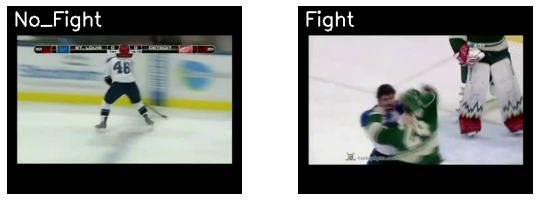

In [2]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))
dir="D:/saad/Violencedetcection/data"
# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir(dir)
 
# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 2)
 
# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):
 
    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]
 
    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'D:/saad/Violencedetcection/data/{selected_class_Name}')
 
    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'D:/saad/Violencedetcection/data/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()
 
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [3]:
IMAGE_HEIGHT , IMAGE_WIDTH = 128, 128
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20
 
# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "D:/saad/Violencedetcection/data/"
 
# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["Fight", "No_Fight"]

In [4]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''
 
    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)
 
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
 
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
 
        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
 
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Return the frames list.
    return frames_list

In [5]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''
 
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)
 
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
 
                # Append the data to their repective lists.
                
                features.append(frames)
                    
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [6]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Fight
Extracting Data of Class: No_Fight


In [7]:
features=features.reshape(20000,128,128,3)

In [8]:
IMG_SIZE=[128,128]
model=tf.keras.applications.VGG16(input_shape=IMG_SIZE+ [3],include_top=False,weights="imagenet")
for layer in model.layers:
    layer.trainable==False
#model.summary()




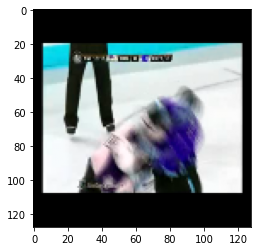

In [9]:
plt.imshow(features[1])

In [10]:
resnet50_feature = model.predict(features)

625/625 [==============================] - 27s 30ms/step


In [11]:
resnet50_feature.shape

(20000, 4, 4, 512)

In [12]:
resnet50_feature=resnet50_feature.reshape(1000,20,-1)

In [13]:
resnet50_feature.shape

(1000, 20, 8192)

In [14]:
#labels = to_categorical(labels)
x_train, x_test, y_train, y_test = train_test_split(resnet50_feature, labels, test_size = 0.1,random_state = True)

In [15]:
#x_train=x_train / 255.
y_train=to_categorical(y_train)

In [16]:
print("Training features  \t",x_train.shape)
print("Training labels  \t",y_train.shape)

Training features  	 (900, 20, 8192)
Training labels  	 (900, 2)


In [17]:
#Reshape
input_shape=x_train.reshape(900,20,-1)
input_shape.shape

(900, 20, 8192)

In [19]:
model = Sequential()
model.add(LSTM(32, return_sequences=True,input_shape=(20,8192)))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(LSTM(64))# return a single vector of dimension 32
model.add(Dropout(0.3))
model.add(Dense(2,activation='softmax'))
#opt = keras.optimizers.Adam(learning_rate=0.01)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 32)            1052800   
                                                                 
 seq_self_attention (SeqSelf  (None, 20, 32)           2113      
 Attention)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 20, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 64)                24832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                        

In [20]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [21]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ["accuracy"])

In [22]:
model_training_history =  model.fit(x_train, y_train, epochs=20, batch_size=32,verbose=1, validation_split = 0.2)

Epoch 1/20
23/23 [==============================] - 6s 75ms/step - loss: 0.3728 - accuracy: 0.8583 - val_loss: 0.3072 - val_accuracy: 0.8778
Epoch 2/20
23/23 [==============================] - 0s 20ms/step - loss: 0.2395 - accuracy: 0.9208 - val_loss: 0.1547 - val_accuracy: 0.9667
Epoch 3/20
23/23 [==============================] - 0s 22ms/step - loss: 0.1863 - accuracy: 0.9417 - val_loss: 0.1538 - val_accuracy: 0.9611
Epoch 4/20
23/23 [==============================] - 1s 22ms/step - loss: 0.1484 - accuracy: 0.9583 - val_loss: 0.1425 - val_accuracy: 0.9611
Epoch 5/20
23/23 [==============================] - 1s 22ms/step - loss: 0.1347 - accuracy: 0.9583 - val_loss: 0.1629 - val_accuracy: 0.9611
Epoch 6/20
23/23 [==============================] - 1s 23ms/step - loss: 0.1149 - accuracy: 0.9625 - val_loss: 0.1300 - val_accuracy: 0.9556
Epoch 7/20
23/23 [==============================] - 1s 23ms/step - loss: 0.0759 - accuracy: 0.9819 - val_loss: 0.1538 - val_accuracy: 0.9611
Epoch 8/20
23

In [23]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
 
    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
 
    # Add title to the plot.
    plt.title(str(plot_name))
 
    # Add legend to the plot.
    plt.legend()

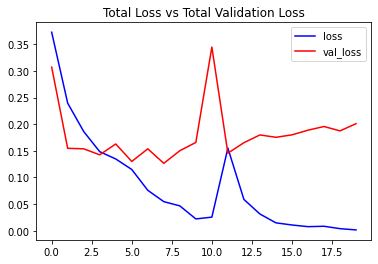

In [24]:
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

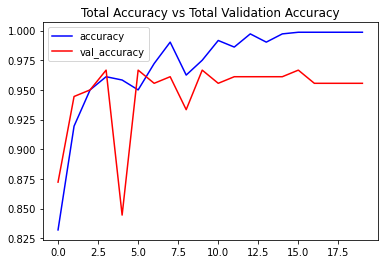

In [24]:
plot_metric(model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

In [25]:
model.save('cnn_Attention_lstm.h5')

In [26]:
x_test=x_test.reshape(100,20,-1)

4/4 [==============================] - 0s 44ms/step
** Confusion Matrix **
[[47  2]
 [ 2 49]]
** Classification Report **
              precision    recall  f1-score   support

       Fight       0.96      0.96      0.96        49
     NoFight       0.96      0.96      0.96        51

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



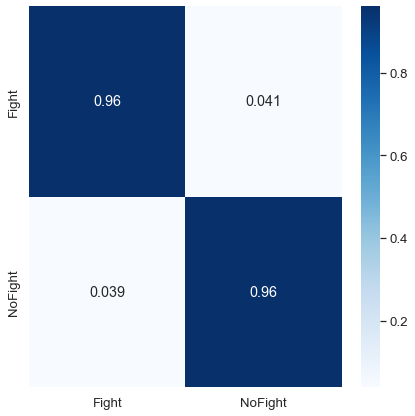

In [28]:
from sklearn.metrics import  confusion_matrix
import matplotlib.pyplot as plot
import seaborn as sn
import pandas as pd
import seaborn as sns
import seaborn as sn
from sklearn.metrics import  confusion_matrix
from sklearn.metrics import classification_report 
import numpy as np
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)

target_names = ["Fight","NoFight"] 
cm = confusion_matrix(y_test, y_pred)
print("** Confusion Matrix **")
print(cm)
print("** Classification Report **")
print(classification_report(y_test, y_pred, target_names=target_names))
classes=2
con = np.zeros((classes,classes))
for x in range(classes):
    for y in range(classes):
        con[x,y] = cm[x,y]/np.sum(cm[x,:])

plt.figure(figsize=(7,7))
sn.set(font_scale=1.2) # for label size
df = sns.heatmap(con, annot=True,fmt='.2', cmap='Blues',xticklabels= target_names , yticklabels= target_names)
df.figure.savefig("./cnn_Attention_lstm.png")
plt.show()